# Effects of Initial State of Charge and C-rate on SEI Growth in Zero-dimensional SEI Models
> This notebook analyses how the initial state of charge (SOC_0) affects SEI growth during discharge across PyBaMM zero-dimensional SEI models: ("reaction limited","solvent-diffusion limited", "ec reaction limited", "electron-migration limited",   "interstitial-diffusion limited",  "VonKolzenberg2020") \
> We test nine initial SOC values (0.1 to 0.9) and find:
> - Higher initial SOC leads to more SEI growth across all models, due to longer discharge times.
> - C-rate does not affect SEI growth patterns, except in the solvent reaction model [Yang et al. (2017)](https://www.sciencedirect.com/science/article/abs/pii/S0378775317307619).
> - When discharge times for all SOC_0 values are same (i.e. different C-rate), each model shows distinct behaviour. 


Internal t = 481.577 and h = 2.24289e-14 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 5.60723e-15 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 5.60723e-15 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 3.50452e-15 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 3.50452e-15 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 2.19032e-15 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 5.47581e-16 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 1.36895e-16 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 1.36895e-16 are such that t + h = t on the 

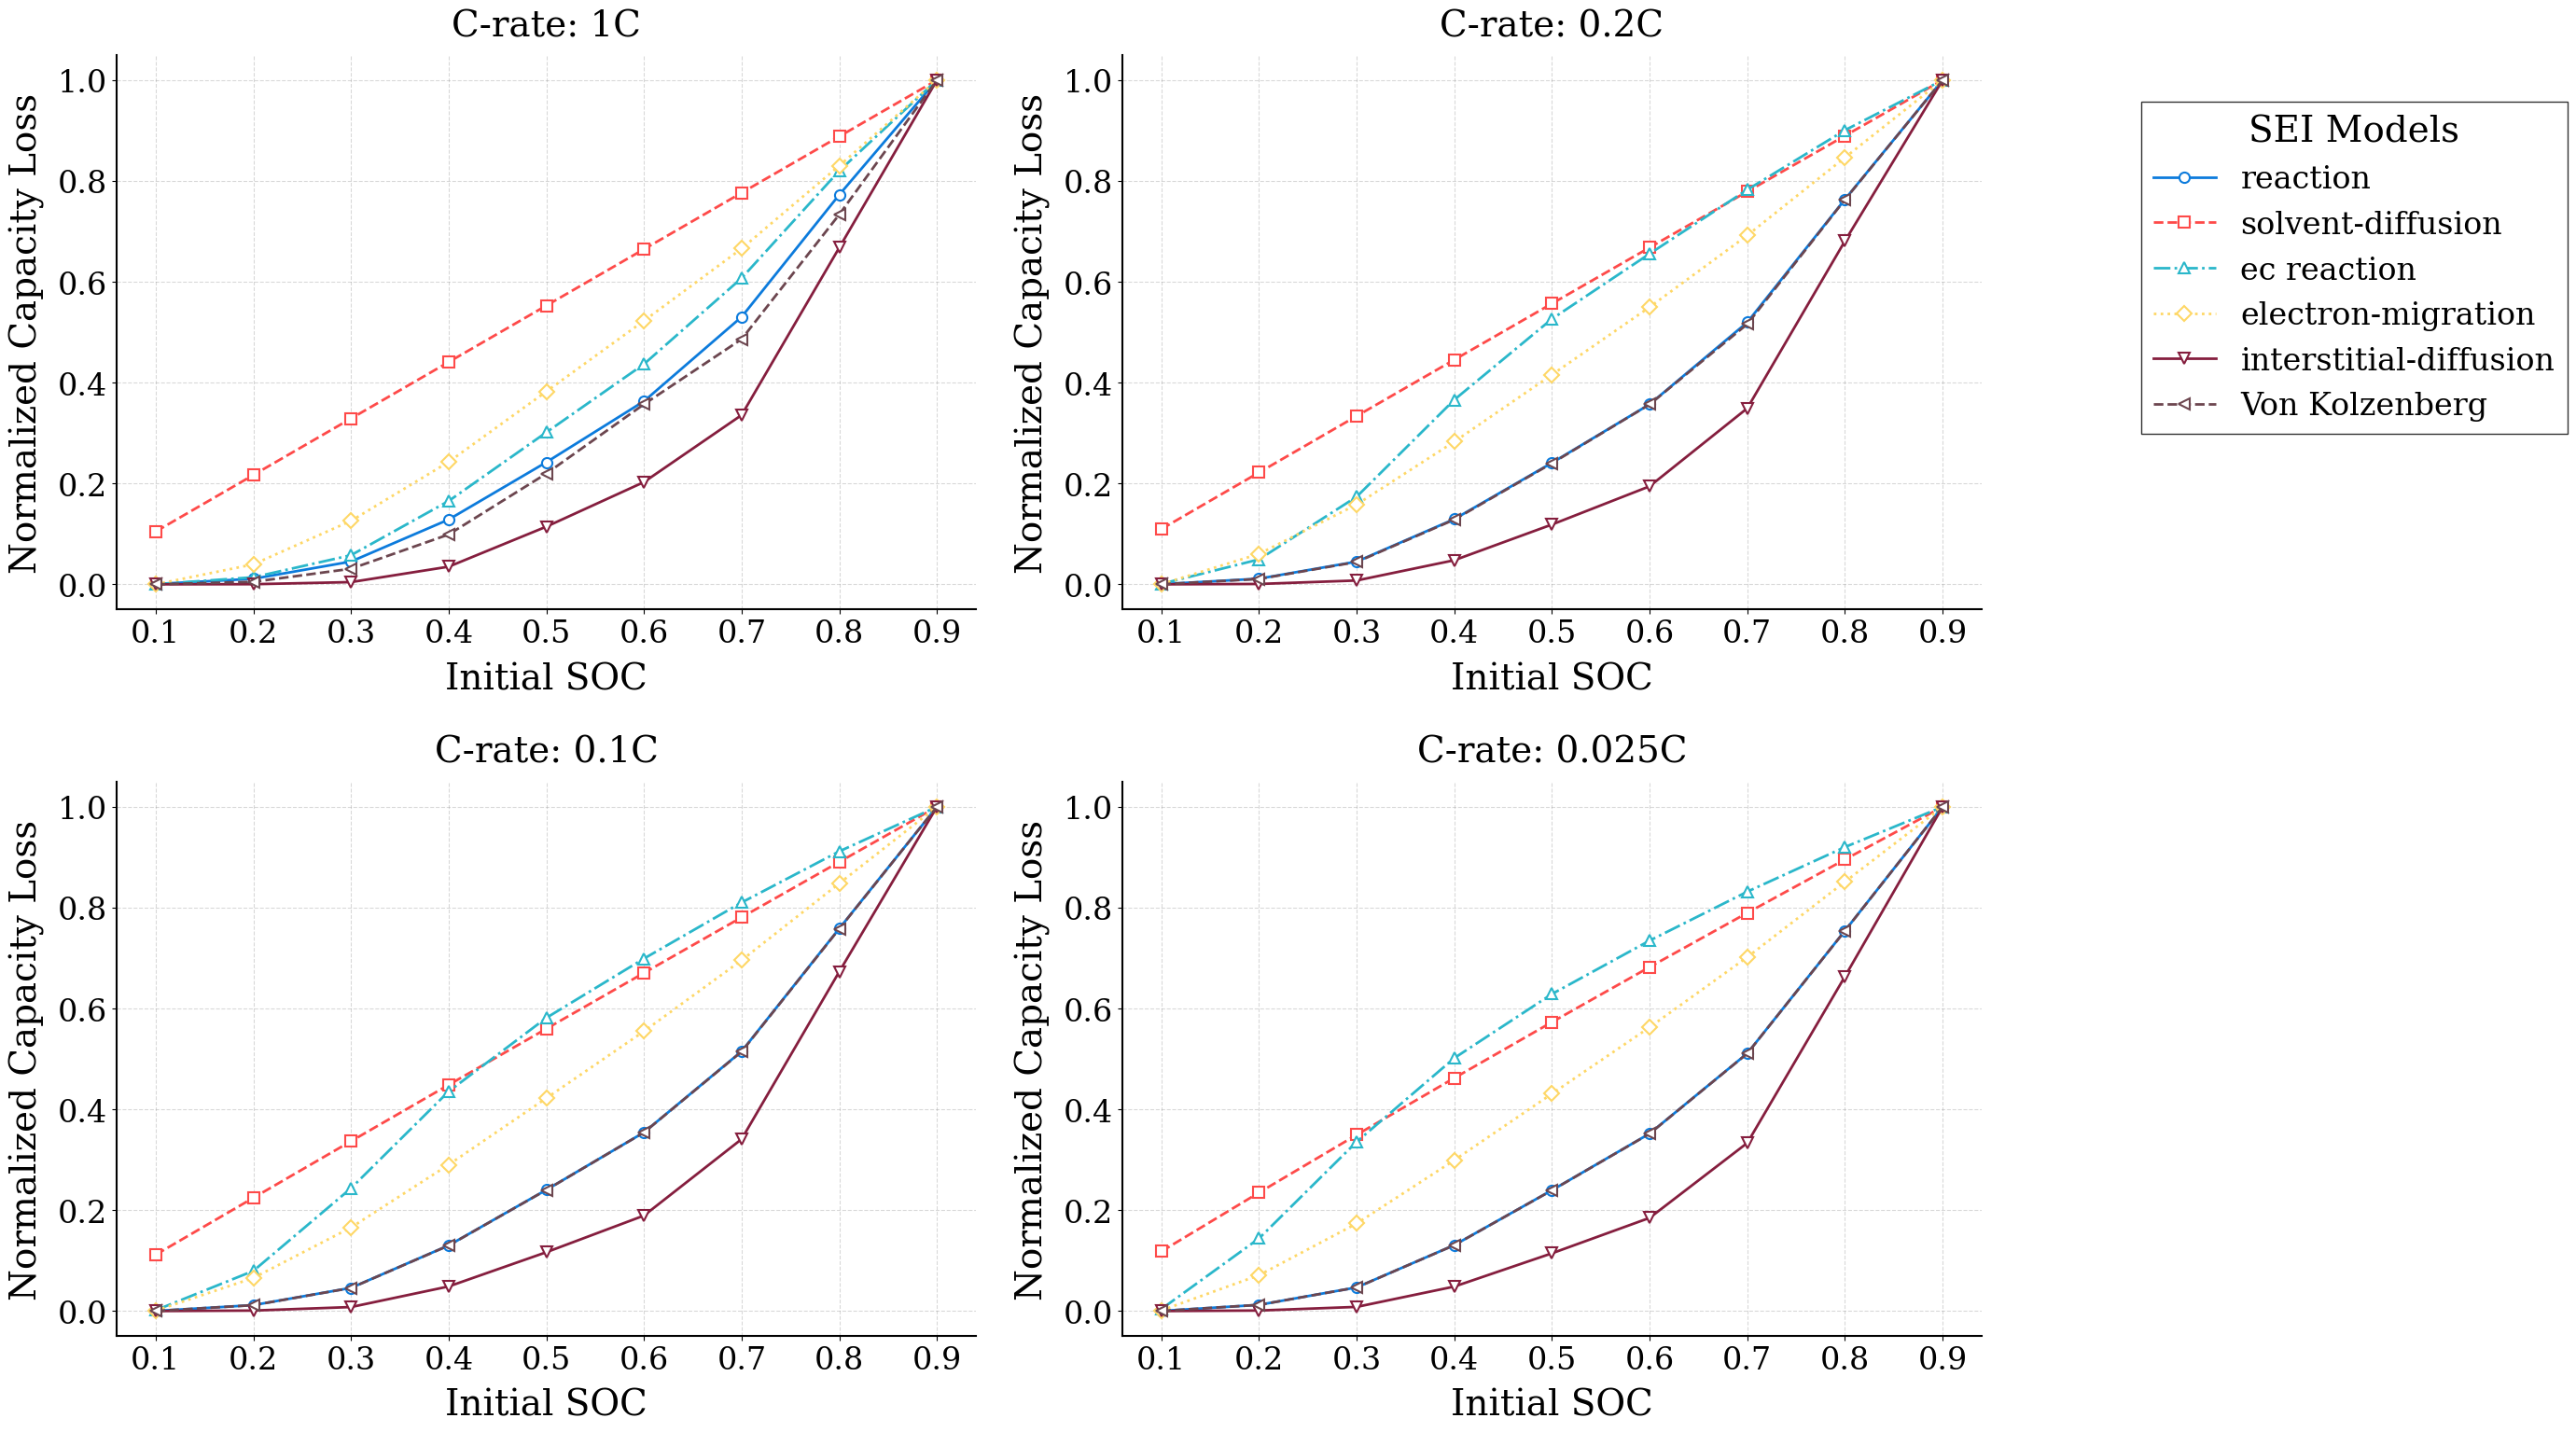

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Update plot parameters with larger font sizes
plt.rcParams.update({
    'font.size': 28,  # Increased base font size
    'font.family': 'serif',
    'axes.labelsize': 28,  # Increased label size
    'axes.titlesize': 28,  # Increased title size
    'xtick.labelsize': 24,  # Increased tick label size
    'ytick.labelsize': 24,
    'legend.fontsize': 24,  # Increased legend font size
    'axes.linewidth': 1.5,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'lines.markersize': 8,
    'lines.linewidth': 2.0,
})

# Setup parameters
no_cycles = 1
soc_0 = np.arange(0.1, 1.0, 0.1)  # Changed to np.arange for even spacing
base_c_rates = [1, 1/5, 1/10, 1/40]

# Define SEI models
sei_options = [
    "reaction limited",
    "solvent-diffusion limited",
    "ec reaction limited",
    "electron-migration limited",
    "interstitial-diffusion limited",
    "VonKolzenberg2020"
]

# Professional color scheme
colors = ['#0C7BDC', '#FE4A49', '#2AB7CA', '#FED766', '#851E3E', '#6C464F']
markers = ['o', 's', '^', 'D', 'v', '<']
line_styles = ['-', '--', '-.', ':', '-', '--']

# Create 2x2 subplot figure with wider aspect ratio
fig, axes = plt.subplots(2, 2, figsize=(22, 16))  # Slightly increased figure size
axes = axes.flatten()

# Set up model parameters
param = pybamm.ParameterValues("Chen2020")
param.update({
    'Initial SEI thickness [m]': 5e-9,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'Tunneling distance for electrons [m]': 5,
    'Tunneling barrier factor [m-1]': 1/2.0e-9,
}, check_already_exists=False)

# Loop through different C-rates
for rate_idx, c_rate in enumerate(base_c_rates):
    # Create experiment for current C-rate
    exp = pybamm.Experiment([(f"Discharge at {c_rate}C until 2.5 V",)] * no_cycles)
    
    # Create and solve models for each SEI option
    for model_idx, sei_option in enumerate(sei_options):
        model = pybamm.lithium_ion.SPM({
            "particle": "uniform profile",
            "SEI porosity change": "false",
            "SEI": sei_option
        })
        
        sim = pybamm.Simulation(model, parameter_values=param, experiment=exp)
        
        # Solve for each initial SOC
        Q_sei = []
        for soc in soc_0:
            sol = sim.solve(initial_soc=soc)
            Q_sei.append(np.max(sol['Total capacity lost to side reactions [A.h]'].entries))
        
        Q_sei_normalized = np.array(Q_sei) / np.max(Q_sei)
        
        # Create label
        label = sei_option.replace(" limited", "").replace("VonKolzenberg2020", "Von Kolzenberg")
        plot_label = label if rate_idx == 0 else None
        
        # Plot with enhanced styling
        axes[rate_idx].plot(soc_0, Q_sei_normalized,
                          color=colors[model_idx],
                          label=plot_label,
                          marker=markers[model_idx],
                          linestyle=line_styles[model_idx],
                          markerfacecolor='white',
                          markeredgewidth=1.5,
                          markersize=8)
        
        # Set x-ticks explicitly
        axes[rate_idx].set_xticks(np.arange(0.1, 1.0, 0.1))
        
        # Customize each subplot
        axes[rate_idx].set_xlabel('Initial SOC', fontsize=28, labelpad=10)
        axes[rate_idx].set_ylabel('Normalized Capacity Loss', fontsize=28, labelpad=10)
        axes[rate_idx].grid(True, alpha=0.3)
        axes[rate_idx].set_title(f'C-rate: {c_rate}C', fontsize=28, pad=15)
        axes[rate_idx].spines['top'].set_visible(False)
        axes[rate_idx].spines['right'].set_visible(False)
        axes[rate_idx].tick_params(axis='both', which='major', labelsize=24)

# Add legend to the right side of the figure
fig.legend(bbox_to_anchor=(1.05, 0.8),
          loc='center left',
          title='SEI Models',
          frameon=True,
          edgecolor='black',
          fancybox=False,
          fontsize=24,
          title_fontsize=28)

plt.tight_layout()
plt.subplots_adjust(right=0.98)  # Adjusted to accommodate larger legend
plt.show()

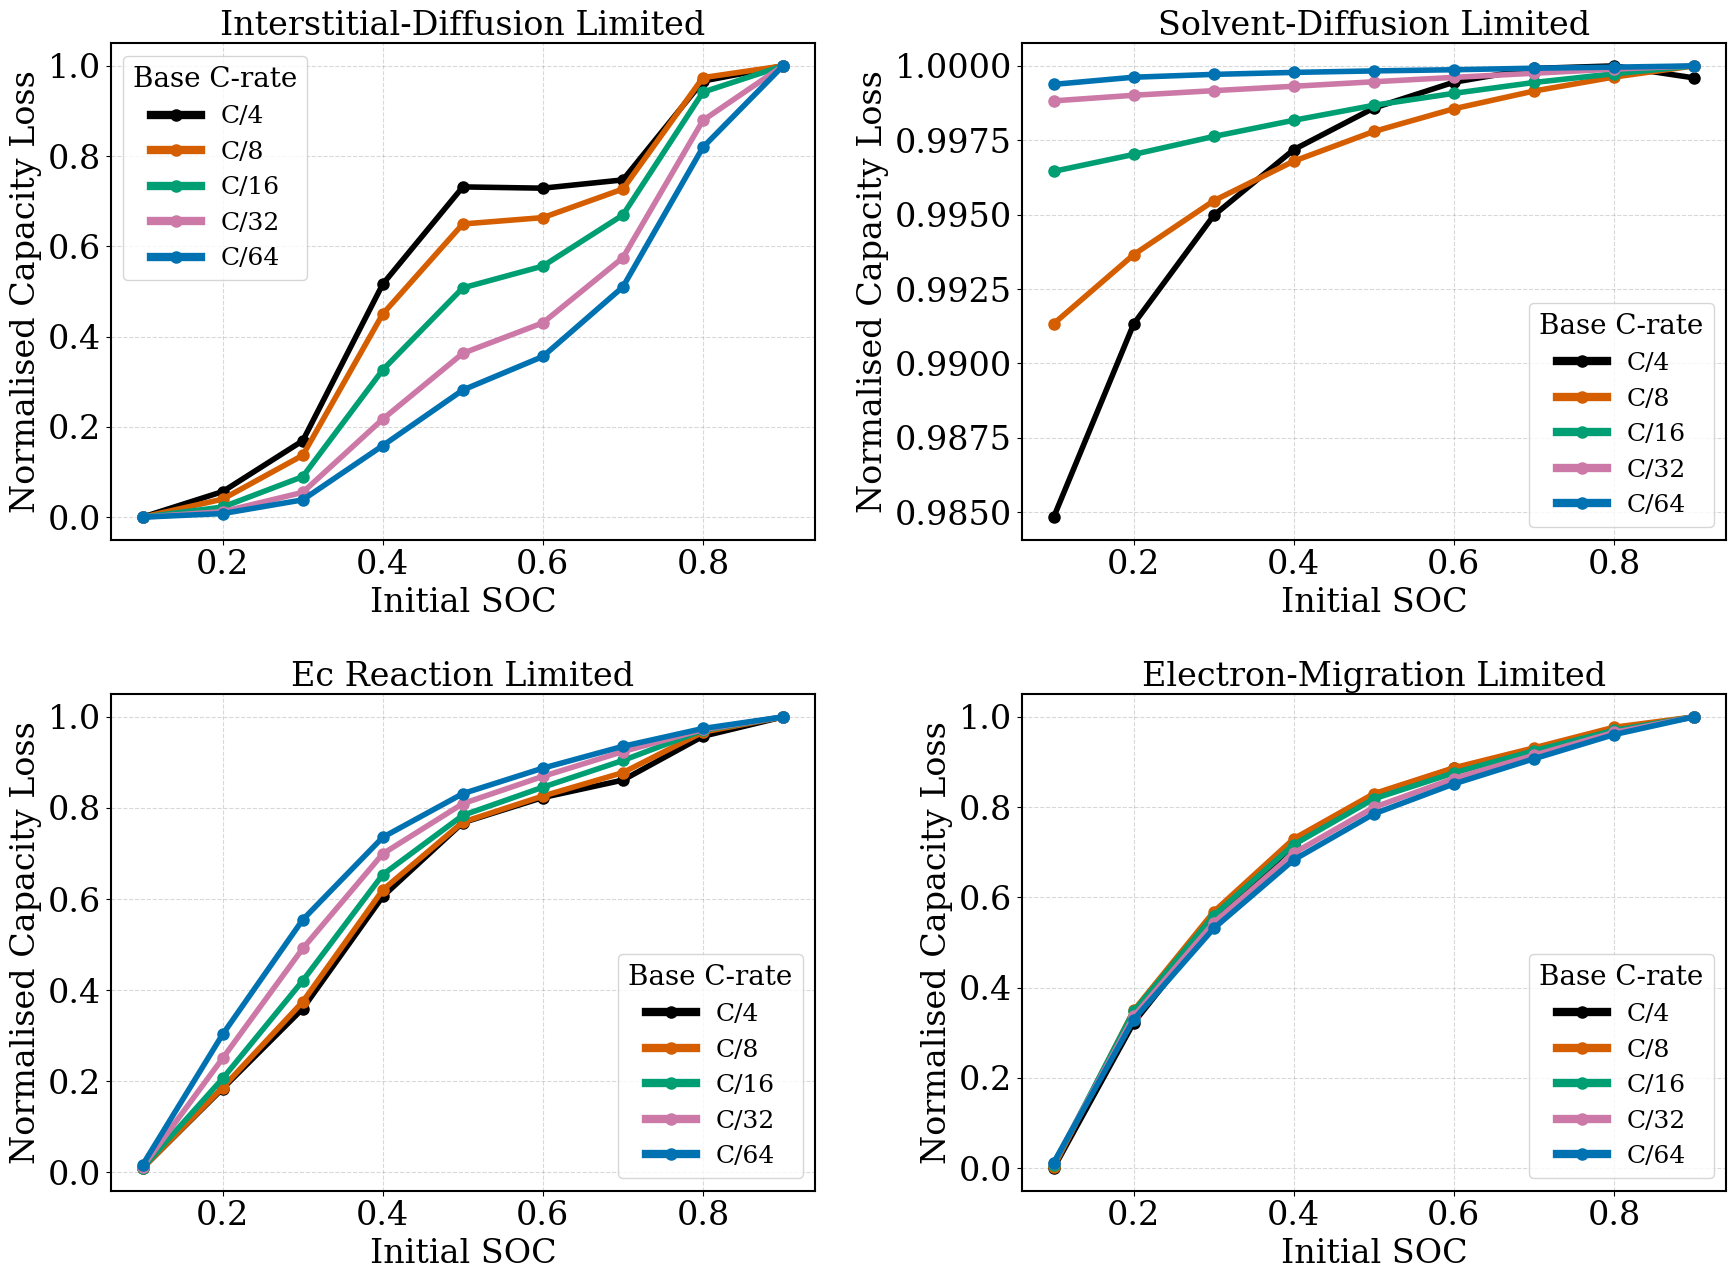

In [2]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Setup parameters
no_cycles = 1

soc_0 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
base_c_rates = [1/4, 1/8, 1/16, 1/32, 1/64]

# Define the four SEI options
sei_options = [
    "interstitial-diffusion limited",
    "solvent-diffusion limited",
    "ec reaction limited",
    "electron-migration limited",
]

# Define an improved colorblind-friendly color palette with maximum contrast
# Matching the color palette from the reference code
colorblind_palette = [
    "#000000",  # black
    "#D55E00",  # vermillion/red
    "#009E73",  # green
    "#CC79A7",  # pink/purple
    "#0072B2",  # blue
]

# Create figure with subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Font sizes - using the same values from the reference code
AXIS_LABEL_SIZE = 24
TICK_LABEL_SIZE = 24
LEGEND_FONT_SIZE = 24
TITLE_FONT_SIZE = 24

# Line thickness (increased from 2 to 4 as in the reference)
LINE_WIDTH = 4

# Loop through each SEI option
for subplot_idx, sei_option in enumerate(sei_options):
    ax = axes[subplot_idx]
    
    # Store results for each base C-rate
    for rate_idx, base_c_rate in enumerate(base_c_rates):
        # Calculate proportional C-rates
        c_rates = [(soc/soc_0[0]) * base_c_rate for soc in soc_0]
        
        # Create experiments
        experiments = []
        for c_rate in c_rates:
            exp = pybamm.Experiment(
                [(f"Discharge at {c_rate}C until 2.5 V",)] * no_cycles
            )
            experiments.append(exp)
        
        # Set up model parameters
        param = pybamm.ParameterValues("Chen2020")
        param.update({
            'Initial SEI thickness [m]': 5e-9,
            'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
            'Tunneling distance for electrons [m]': 0,
        }, check_already_exists=False)
        
        # Create model with current SEI option
        models = [pybamm.lithium_ion.SPM({
            "SEI porosity change": "false",
            "SEI": sei_option
        })]
        
        # Create and solve simulations
        sims = []
        for exp in experiments:
            sims.extend([pybamm.Simulation(model, parameter_values=param,
                                      experiment=exp) for model in models])
        sols = [sim.solve(initial_soc=soc) for sim, soc in zip(sims, soc_0)]
        
        # Extract and normalize capacity loss results
        Q_sei = []
        for sol in sols:
            Q_sei.append(np.max(sol['Total capacity lost to side reactions [A.h]'].entries))
        Q_sei_normalized = np.array(Q_sei) / np.max(Q_sei)
        
        # Plot normalized capacity loss with increased line width
        label = f'C/{int(1/base_c_rate)}'
        ax.plot(soc_0, Q_sei_normalized, 'o-', 
                color=colorblind_palette[rate_idx],
                label=label, 
                linewidth=LINE_WIDTH, 
                markersize=8)  # Increased markersize for better visibility
    
    # Customize subplot with larger font sizes
    ax.set_xlabel('Initial SOC', fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel('Normalised Capacity Loss', fontsize=AXIS_LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_SIZE)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_title(f'{sei_option.title()}', fontsize=TITLE_FONT_SIZE)
    
    # Create legend with larger font
    legend = ax.legend(title='Base C-rate', fontsize=LEGEND_FONT_SIZE-6)
    legend.get_title().set_fontsize(LEGEND_FONT_SIZE-4)
    
    # Increase the line width in the legend
    for line in legend.get_lines():
        line.set_linewidth(LINE_WIDTH + 2)

# Adjust layout
plt.tight_layout(rect=[0, 0.02, 1, 0.98])

# Save figure with high resolution
plt.savefig('sei_models_comparison.png', dpi=300, bbox_inches='tight', format='png')
# plt.savefig('sei_models_comparison.pdf', bbox_inches='tight', format='pdf')  # Also save as PDF for vector quality

plt.show()

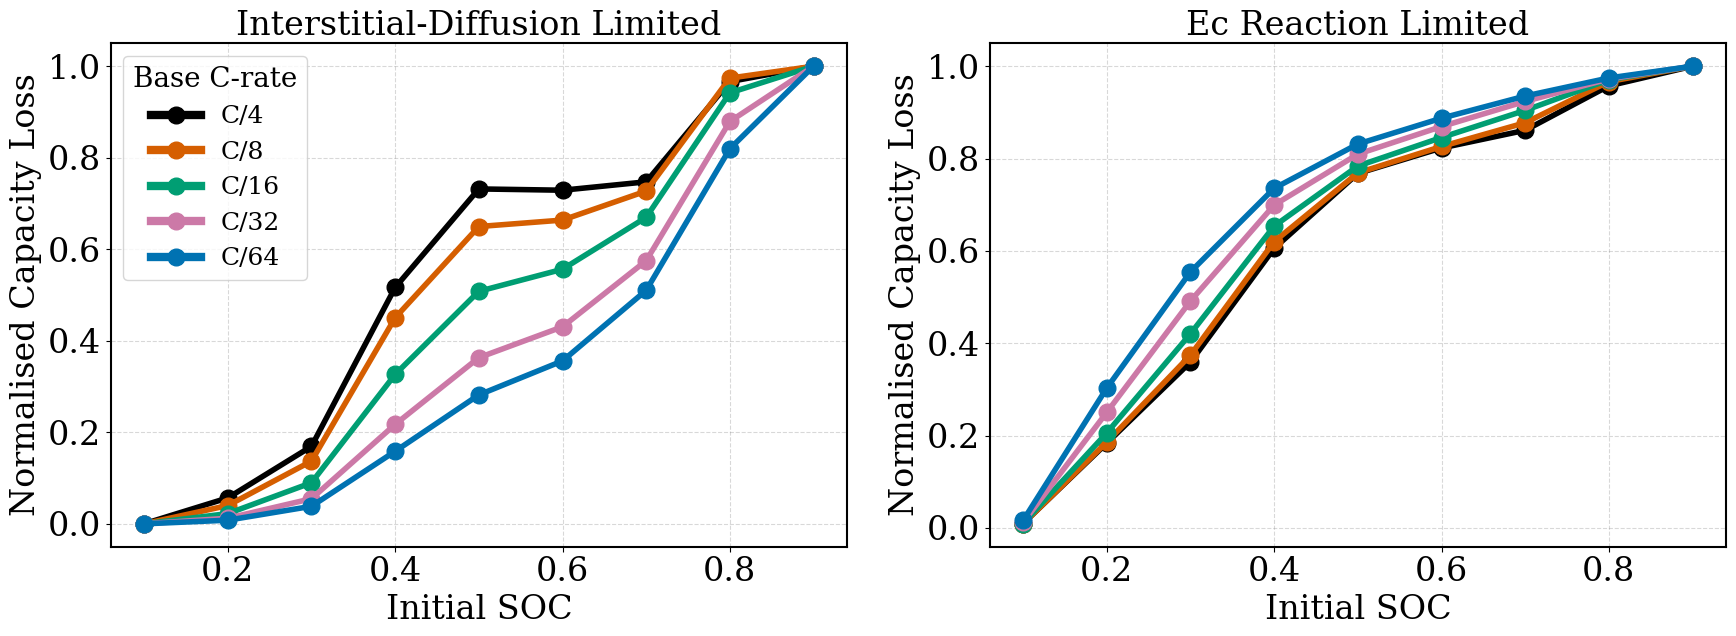

In [ ]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Setup parameters
no_cycles = 1

soc_0 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
base_c_rates = [1/4, 1/8, 1/16, 1/32, 1/64]

# Define only the two SEI options we want
sei_options = [
    "interstitial-diffusion limited",
    "ec reaction limited",
]

# Define an improved colorblind-friendly color palette with maximum contrast
# Matching the color palette from the reference code
colorblind_palette = [
    "#000000",  # black
    "#D55E00",  # vermillion/red
    "#009E73",  # green
    "#CC79A7",  # pink/purple
    "#0072B2",  # blue
]

# Create figure with subplots (1x2 grid)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Font sizes - using the same values from the reference code
AXIS_LABEL_SIZE = 24
TICK_LABEL_SIZE = 24
LEGEND_FONT_SIZE = 24
TITLE_FONT_SIZE = 24

# Line thickness
LINE_WIDTH = 4

# Store legend handles and labels
legend_handles = []
legend_labels = []

# Loop through each SEI option
for subplot_idx, sei_option in enumerate(sei_options):
    ax = axes[subplot_idx]
    
    # Store results for each base C-rate
    for rate_idx, base_c_rate in enumerate(base_c_rates):
        # Calculate proportional C-rates
        c_rates = [(soc/soc_0[0]) * base_c_rate for soc in soc_0]
        
        # Create experiments
        experiments = []
        for c_rate in c_rates:
            exp = pybamm.Experiment(
                [(f"Discharge at {c_rate}C until 2.5 V",)] * no_cycles
            )
            experiments.append(exp)
        
        # Set up model parameters
        param = pybamm.ParameterValues("Chen2020")
        param.update({
            'Initial SEI thickness [m]': 5e-9,
            'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
            'Tunneling distance for electrons [m]': 0,
        }, check_already_exists=False)
        
        # Create model with current SEI option
        models = [pybamm.lithium_ion.SPM({
            "SEI porosity change": "false",
            "SEI": sei_option
        })]
        
        # Create and solve simulations
        sims = []
        for exp in experiments:
            sims.extend([pybamm.Simulation(model, parameter_values=param,
                                      experiment=exp) for model in models])
        sols = [sim.solve(initial_soc=soc) for sim, soc in zip(sims, soc_0)]
        
        # Extract and normalize capacity loss results
        Q_sei = []
        for sol in sols:
            Q_sei.append(np.max(sol['Total capacity lost to side reactions [A.h]'].entries))
        Q_sei_normalized = np.array(Q_sei) / np.max(Q_sei)
        
        # Plot normalized capacity loss with increased line width and larger markers
        label = f'C/{int(1/base_c_rate)}'
        line, = ax.plot(soc_0, Q_sei_normalized, 'o-', 
                color=colorblind_palette[rate_idx],
                linewidth=LINE_WIDTH, 
                markersize=12)  # Further increased markersize for better visibility
        
        # Only store legend handles and labels from the first subplot
        if subplot_idx == 0:
            legend_handles.append(line)
            legend_labels.append(label)
    
    # Customize subplot with larger font sizes
    ax.set_xlabel('Initial SOC', fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel('Normalised Capacity Loss', fontsize=AXIS_LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_SIZE)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Format the title to match the shown image
    if sei_option == "interstitial-diffusion limited":
        title = "Interstitial-Diffusion Limited"
    elif sei_option == "ec reaction limited":
        title = "Ec Reaction Limited"
    else:
        title = sei_option.title()
        
    ax.set_title(title, fontsize=TITLE_FONT_SIZE)

# Place legend inside the first subplot (Interstitial-Diffusion Limited)
legend = axes[0].legend(
    legend_handles, 
    legend_labels,
    loc='upper left',  # Position in upper left corner
    fontsize=LEGEND_FONT_SIZE-6,
    title='Base C-rate',
    frameon=True,
    framealpha=0.8  # Semi-transparent background
)

# Set the legend title font size
legend.get_title().set_fontsize(LEGEND_FONT_SIZE-4)

# Increase the line width in the legend
for line in legend.get_lines():
    line.set_linewidth(LINE_WIDTH + 2)

# Adjust layout without extra space at bottom
plt.tight_layout()

# Save figure with high resolution
# plt.savefig('sei_models_comparison.png', dpi=300, bbox_inches='tight', format='png')
# plt.savefig('sei_models_comparison.pdf', bbox_inches='tight', format='pdf')  # Also save as PDF for vector quality

plt.show()